# Proje Hazırlık Adımları

In [ ]:
import os
import pandas as pd

## Google Drive Bağlantısı

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd
!ls

/content
drive  sample_data


In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/Yapay Zeka Dersi Deri Kanseri Tahmin Projesi"

/content/drive/MyDrive/Colab Notebooks/Yapay Zeka Dersi Deri Kanseri Tahmin Projesi


In [ ]:
!ls

 final_figure.png	  model.h5	  'Yapay Zeka Proje.ipynb'
 HAM10000_images_part_1   model_plot.png
 HAM10000_metadata.csv	  model.png


## Kaggle İşlemleri

In [ ]:
#os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab Notebooks/Yapay Zeka Dersi Deri Kanseri Tahmin Projesi"

In [ ]:
#!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

In [ ]:
#!pwd

In [ ]:
#!unzip \*.zip  && rm *.zip

In [ ]:
#!cp HAM10000_images_part_2/* HAM10000_images_part_1

In [ ]:
#%cd "/content/drive/MyDrive/Colab Notebooks/Deneme/HAM10000_images_part_1"
#!ls -1 | wc -l

In [ ]:
#!rm -r ham10000_images_part_1 ham10000_images_part_2 HAM10000_images_part_2

In [ ]:
#%cd "/content/drive/MyDrive/Colab Notebooks/Yapay Zeka Dersi Deri Kanseri Tahmin Projesi/HAM10000_images_part_1"

In [ ]:
#!ls -1 | wc -l

# Python Kütüphaneler

In [1]:
import os
import itertools
import numpy as np          
import pandas as pd        
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from cv2 import imread, resize

from PIL import ImageTk, Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.core import Dropout, Activation
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, \
     Dense, Input, Activation, Dropout, GlobalAveragePooling2D, AveragePooling2D
from keras import backend as K
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
from keras.models import Model
from sklearn.utils.class_weight import compute_class_weight

In [9]:
skin_df = pd.read_csv('./HAM10000_metadata.csv')
skin_df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


<AxesSubplot:xlabel='dx', ylabel='count'>

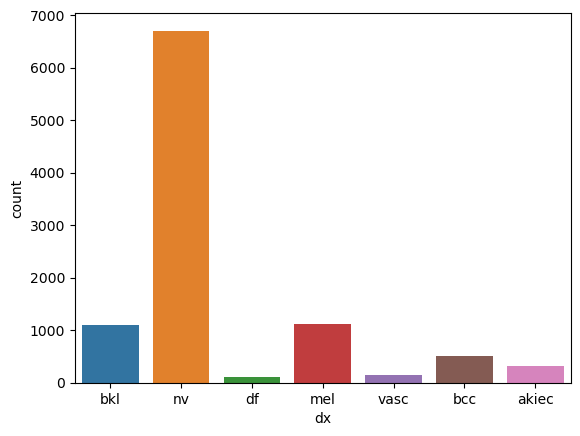

In [10]:
skin_df.info()
sns.countplot(x = "dx", data = skin_df)#dx özelliğini sınıflara göre görselleştirdik.

In [11]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

<AxesSubplot:>

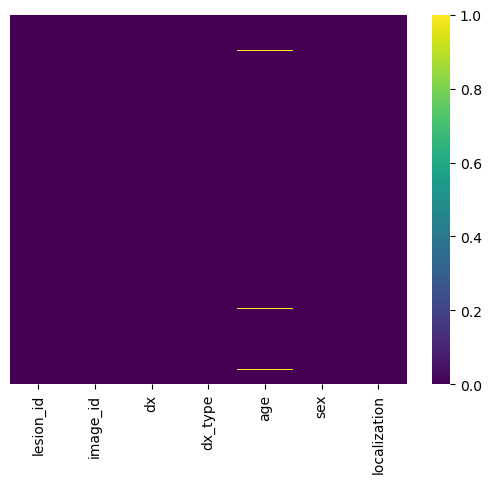

In [12]:
sns.heatmap(skin_df.isnull(),yticklabels=False,cmap="viridis")

In [5]:
skin_df['age'].fillna(int(skin_df['age'].mean()),inplace=True)
skin_df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [6]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_ID_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}


lesion_names = ['Melanocytic nevi','Melanoma','Benign keratosis-like lesions ',
               'Basal cell carcinoma','Actinic keratoses','Vascular lesions',
               'Dermatofibroma']
lesion_names_short = ['nv','mel','bkl','bcc','akiec','vasc','df']


skin_df['lesion_type']= skin_df['dx'].map(lesion_type_dict)
skin_df['lesion_ID'] = skin_df['dx'].map(lesion_ID_dict)


print('Total number of images', len(skin_df))
print('The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels')


skin_df['lesion_type'].value_counts()

Total number of images 10015
The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels


Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: lesion_type, dtype: int64

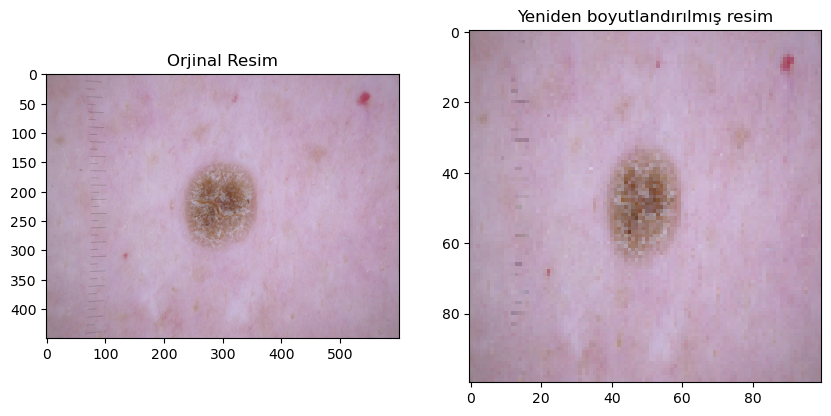

In [7]:

fname_images = np.array(skin_df['image_id'])
file_to_read ='./HAM10000_images_part_1/'+str(fname_images[13])+'.jpg'


img = imread(file_to_read)
img2 = resize(img, (100, 100))


plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[:, :, ::-1])
plt.title('Orjinal Resim')
plt.subplot(1, 2, 2)
plt.imshow(img2[:, :, ::-1])
plt.title('Yeniden boyutlandırılmış resim')
plt.show()

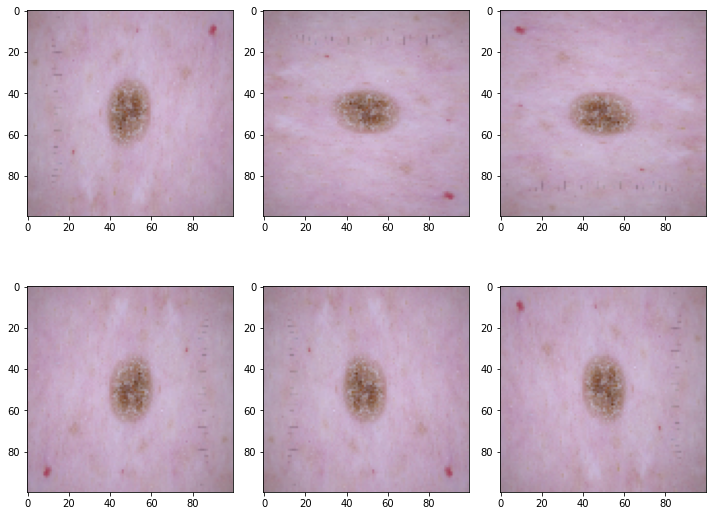

In [ ]:
def produce_new_img(img2: cv2) -> tuple:
    imga = cv2.rotate(img2, cv2.ROTATE_90_CLOCKWISE)
    imgb = cv2.rotate(img2, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imgc = cv2.rotate(img2, cv2.ROTATE_180)
    imgd = cv2.flip(img2, 0)
    imge = cv2.flip(img2, 1)
    new_imges = imga, imgb, imgc, imgd ,imge
    return new_imges

def show_example() -> None:
    plt.figure(figsize = (10, 8))
    plt.subplot(2, 3, 1)
    plt.imshow(img2[:, :, ::-1])
    for i in range(5):
        plt.subplot(2, 3, 2+i)
        plt.imshow(new_img[i][:, :, ::-1])
    plt.tight_layout()
    plt.show()

new_img = produce_new_img(img2)

show_example()

In [ ]:
x = []     
y = []         

liste1 = os.listdir('./HAM10000_images_part_1/')

for i in range(len(liste1)):

    fname_image = liste1[i]
    fname_ID = fname_image.replace('.jpg', '')
    file_to_read ='./HAM10000_images_part_1/' + str(fname_image) 
    img = imread(file_to_read)                             
    img2 = resize(img,(100, 100))                            
    x.append(img2)                                              
      

    output = np.array(skin_df[skin_df['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])
    

    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            x.append(new_img[i])
            y.append(output[0])


    if i % 100 == 0:
        print(i, 'images loaded')

0 images loaded
300 images loaded
500 images loaded
700 images loaded
900 images loaded
1000 images loaded
1100 images loaded
1200 images loaded
1300 images loaded
1600 images loaded
1700 images loaded
1800 images loaded
2000 images loaded
2100 images loaded
2200 images loaded
2500 images loaded
2600 images loaded
2800 images loaded
3000 images loaded
3100 images loaded
3200 images loaded
3500 images loaded
3600 images loaded
3700 images loaded
3900 images loaded
4000 images loaded
4100 images loaded
4200 images loaded
4500 images loaded
4600 images loaded
4700 images loaded
4900 images loaded
5000 images loaded
5100 images loaded
5200 images loaded
5300 images loaded
5500 images loaded
5600 images loaded
5700 images loaded
5900 images loaded
6000 images loaded
6100 images loaded
6300 images loaded
6400 images loaded
6500 images loaded
6600 images loaded
6700 images loaded
6800 images loaded
6900 images loaded
7000 images loaded
7100 images loaded
7200 images loaded
7300 images loaded


In [ ]:
x = np.array(x)
y = np.array(y)
y_train = to_categorical(y, num_classes = 7)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x,                  
                                                    y_train,            
                                                    test_size = 0.20,  
                                                    random_state = 50, 
                                                    stratify = y)     

print('Train dataset shape', X_train.shape)
print('Test dataset shape', X_test.shape)

Train dataset shape (21252, 100, 100, 3)
Test dataset shape (5313, 100, 100, 3)


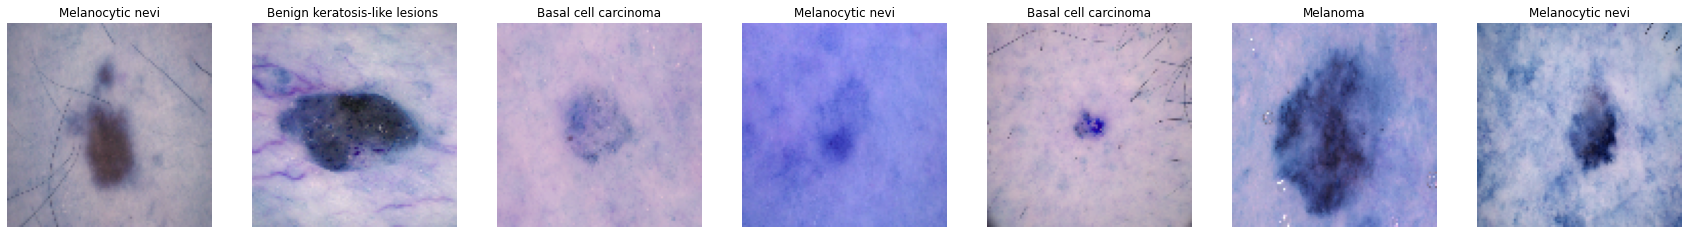

In [ ]:
def show_neg_figuers() -> None:
    """ Display negative figuers of the classes. """
    
    _, ax = plt.subplots(1, 7, figsize = (30, 30))
    for i in range(7):
        ax[i].set_axis_off()                                   
        ax[i].imshow(X_train[i])                               
        ax[i].set_title(lesion_names[np.argmax(y_train[i])])    
show_neg_figuers()

In [ ]:
def est_class_weights(dis_id: np.array) -> dict:

    class_weights = np.around(compute_class_weight(class_weight = 'balanced', classes = np.unique(dis_id), y = y), 2)
    class_weights = dict(zip(np.unique(dis_id), class_weights))

y_id = np.array(skin_df['lesion_ID'])
new_class_weights = est_class_weights(y_id)
print('The problem is unbalanced. We need to provide class-weights')
print(new_class_weights)

The problem is unbalanced. We need to provide class-weights
None


In [ ]:
model = Sequential()
        
#  1. convolutional katman
model.add(Conv2D(filters = 96,
                kernel_size = (11, 11),
                strides = (4, 4),
                activation = 'relu',
                input_shape = (100, 100, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

#  2. convolutional katmann
model.add(Conv2D(filters = 256,
                kernel_size=(5, 5),
                strides=(1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

#  3. convolutional katman
model.add(Conv2D(filters = 384,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 padding="same"))
model.add(BatchNormalization())

#  4. convolutional katman
model.add(Conv2D(filters = 384,
                kernel_size = (1, 1), 
                strides = (1, 1), 
                activation = 'relu', 
                padding = "same"))
model.add(BatchNormalization())

#  5. convolutional katman
model.add(Conv2D(filters = 256, 
                kernel_size = (1, 1),
                strides = (1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))
              
model.add(Flatten())  

#  6. Dense katman:

model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))
              
# 7. Dense katman
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))
              
# 8. output katman
model.add(Dense(7, activation = 'softmax'))


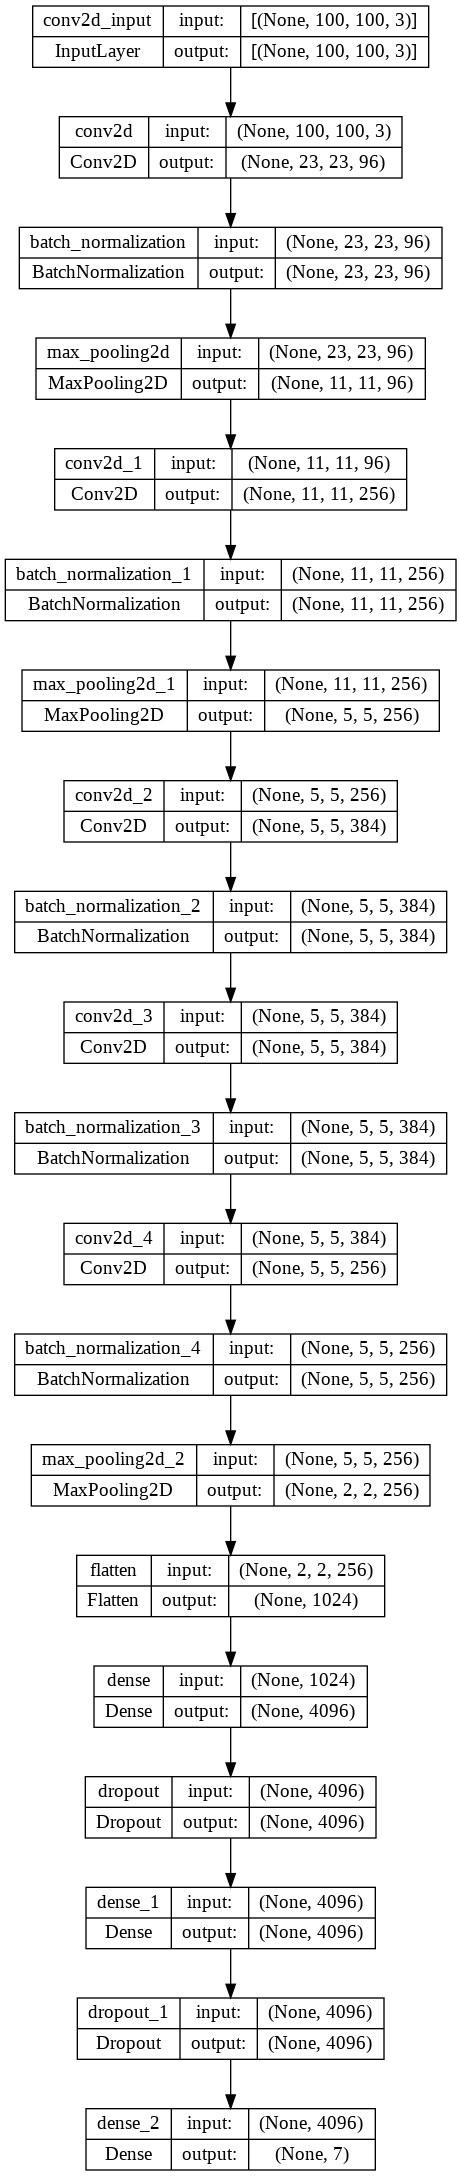

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:

def mod_checkpoint_callback() -> None:

    trained_model = ModelCheckpoint(filepath = 'model.h5',  
                             save_weights_only = False,    
                             monitor = 'val_accuracy',     
                             mode = 'auto',                 
                             save_best_only = True,        
                             verbose = 1)
    return trained_model


early_stopping_monitor = EarlyStopping(patience = 100, monitor = 'val_accuracy')

model_checkpoint_callback = mod_checkpoint_callback()


optimizer = Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-3)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip = True, shear_range = 0.2)
datagen.fit(X_train)

batch_size = 32    
epochs = 100      


history = model.fit(datagen.flow(X_train,y_train),
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    callbacks = [early_stopping_monitor, model_checkpoint_callback],
                    validation_data = (X_test, y_test),
                    class_weight = new_class_weights
                )


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
665/665 [==============================] - ETA: 0s - loss: 1.4241 - accuracy: 0.4871
Epoch 1: val_accuracy improved from -inf to 0.36947, saving model to model.h5
665/665 [==============================] - 78s 98ms/step - loss: 1.4241 - accuracy: 0.4871 - val_loss: 1.8545 - val_accuracy: 0.3695
Epoch 2/100
665/665 [==============================] - ETA: 0s - loss: 1.1143 - accuracy: 0.5670
Epoch 2: val_accuracy improved from 0.36947 to 0.43158, saving model to model.h5
665/665 [==============================] - 65s 98ms/step - loss: 1.1143 - accuracy: 0.5670 - val_loss: 1.4159 - val_accuracy: 0.4316
Epoch 3/100
665/665 [==============================] - ETA: 0s - loss: 1.0199 - accuracy: 0.6028
Epoch 3: val_accuracy improved from 0.43158 to 0.57877, saving model to model.h5
665/665 [==============================] - 65s 98ms/step - loss: 1.0199 - accuracy: 0.6028 - val_loss: 1.0967 - val_accuracy: 0.5788
Epoch 4/100
665/665 [==============================] - ETA: 0s - loss:

In [ ]:
scores = model.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

167/167 [==============================] - 1s 6ms/step - loss: 0.2693 - accuracy: 0.9281
Accuracy: 92.81%


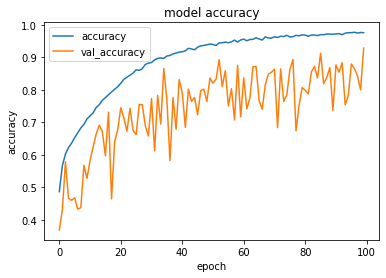

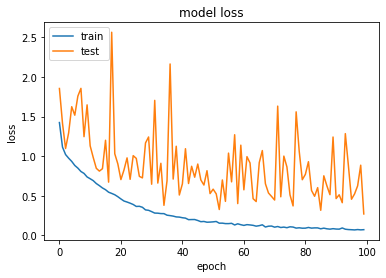

In [ ]:

def display_accuracy() -> None:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
    plt.show()

def display_loss() -> None:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

display_accuracy()
display_loss()

In [ ]:
y_pred = model.predict(X_test)

def test_model() -> tuple:
    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []
    for i in range(len(y_pred)):
        if np.argmax(y_pred[i]) == np.argmax(y_test[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)
        total += 1
    return (total, accurate)

total, accurate = test_model()
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate / total * 100, 3), '%')

167/167 [==============================] - 1s 4ms/step
Total-test-data; 5313 	accurately-predicted-data: 4931 	 wrongly-predicted-data:  382
Accuracy: 92.81 %


In [ ]:
best_model = load_model('./model.h5')

# Compute predictions
y_pred_prob = np.around(best_model.predict(X_test),3)
y_pred = np.argmax(y_pred_prob, axis = 1)
y_test2 = np.argmax(y_test, axis = 1)

167/167 [==============================] - 1s 4ms/step


In [ ]:
# [+] inform the user with model Accuracy %
scores = best_model.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

167/167 [==============================] - 1s 5ms/step - loss: 0.2693 - accuracy: 0.9281
Accuracy: 92.81%


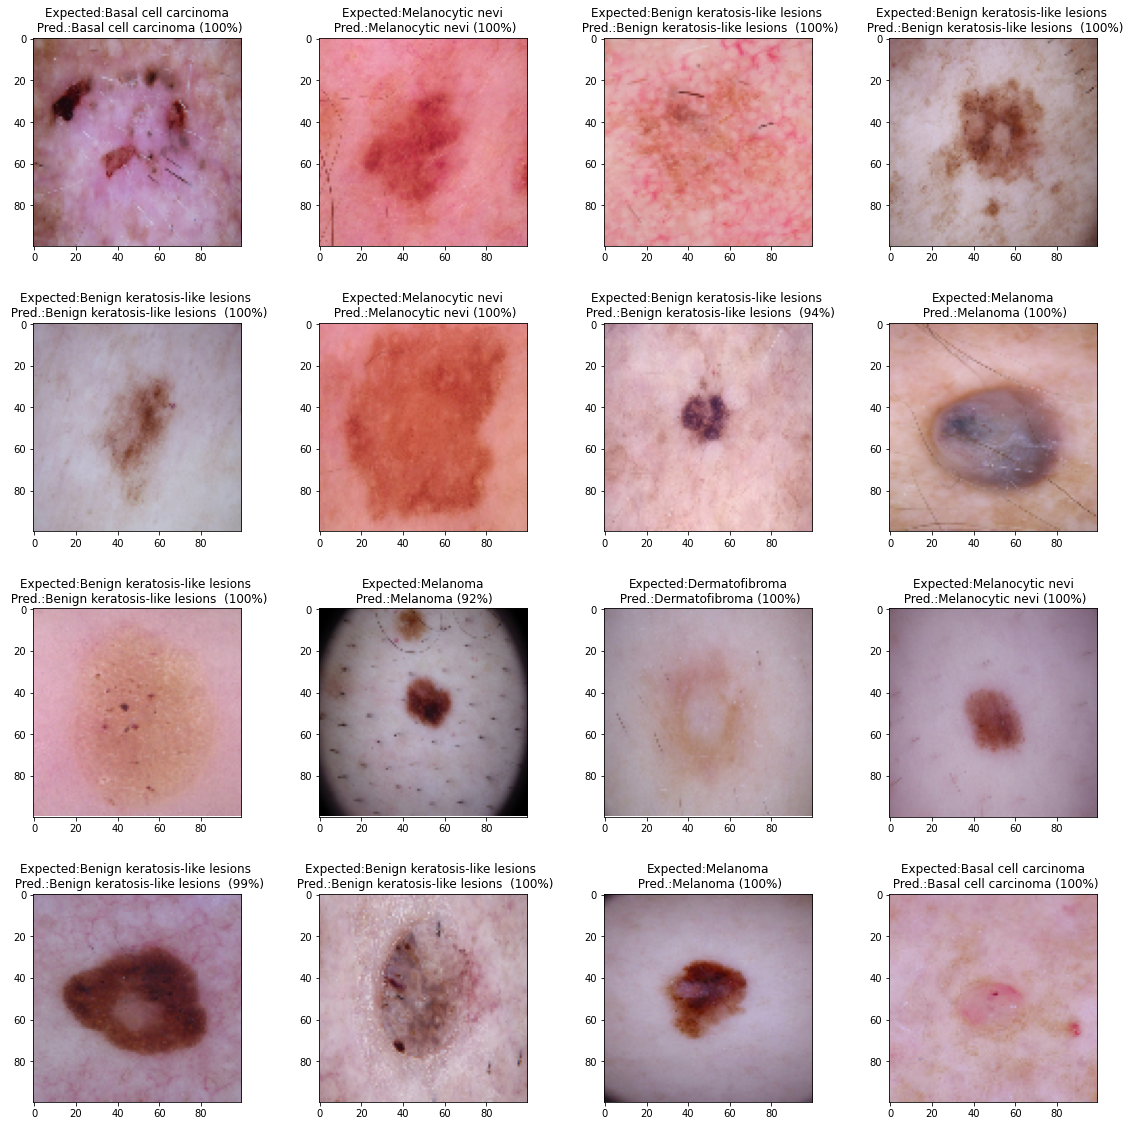

In [ ]:
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    index = i+100
    plt.imshow(X_test[index,:,:,::-1])
    label_exp = lesion_names[y_test2[index]]  
    label_pred = lesion_names[y_pred[index]] 
    label_pred_prob = round(np.max(y_pred_prob[index])*100)
    plt.title('Expected:'+str(label_exp)+'\n Pred.:'+str(label_pred)+' ('+str(label_pred_prob)+'%)')
plt.ylabel('')
plt.tight_layout()
plt.savefig('final_figure.png',dpi=300)
plt.show()

In [ ]:
acc_tot= []

for i in range(7):
    acc_parz = round(np.mean(y_test2[y_test2 == i] == y_pred[y_test2 == i]),2)
    lab_parz = lesion_names[i]
    print('accuracy for',lab_parz,'=',acc_parz)
    acc_tot.append(acc_parz)

accuracy for Melanocytic nevi = 0.88
accuracy for Melanoma = 0.93
accuracy for Benign keratosis-like lesions  = 0.96
accuracy for Basal cell carcinoma = 0.96
accuracy for Actinic keratoses = 0.93
accuracy for Vascular lesions = 0.98
accuracy for Dermatofibroma = 0.94


In [ ]:
acc_tot = np.array(acc_tot)
freq = np.unique(y_test2,return_counts=True)[1]

np.sum(acc_tot*freq)/np.sum(freq)

0.9301712779973651

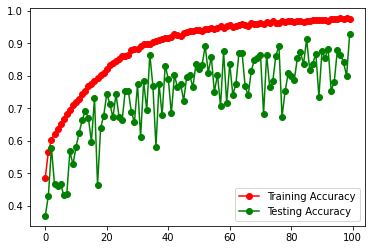

In [ ]:
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

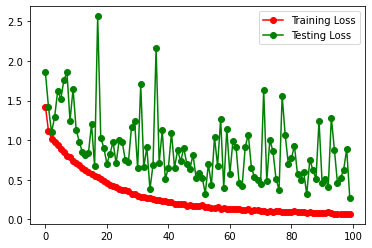

In [ ]:
plt.plot(history.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

In [ ]:
y_pred  = model.predict(X_test).round()

167/167 [==============================] - 1s 7ms/step


In [ ]:
target_names = [f"{lesion_names[i]}" for i in range(7)]
print(classification_report(y_test , y_pred , target_names =target_names ))

                                precision    recall  f1-score   support

              Melanocytic nevi       0.95      0.87      0.91      1341
                      Melanoma       0.92      0.92      0.92      1336
Benign keratosis-like lesions        0.90      0.96      0.93      1319
          Basal cell carcinoma       0.95      0.96      0.96       617
             Actinic keratoses       0.94      0.93      0.93       392
              Vascular lesions       0.98      0.98      0.98       170
                Dermatofibroma       0.98      0.93      0.96       138

                     micro avg       0.93      0.93      0.93      5313
                     macro avg       0.95      0.94      0.94      5313
                  weighted avg       0.93      0.93      0.93      5313
                   samples avg       0.93      0.93      0.93      5313



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


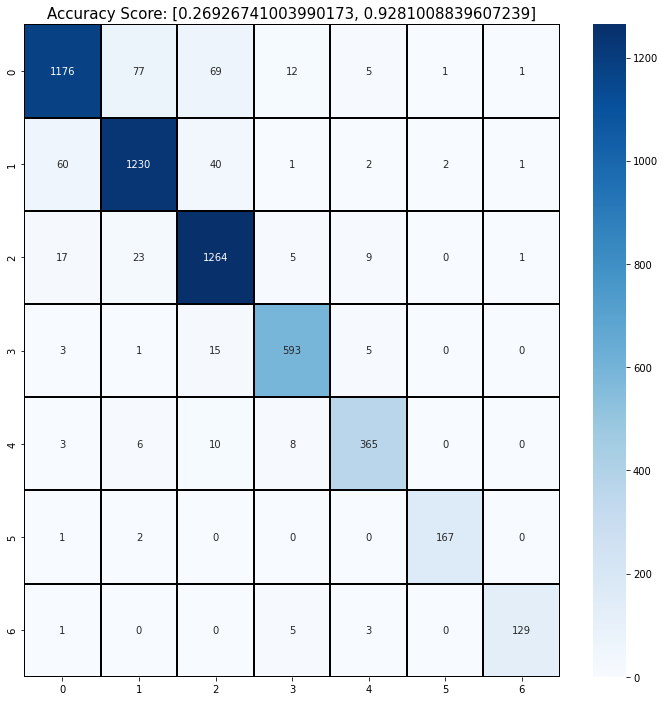

In [ ]:
cm = confusion_matrix(y_test.argmax(axis = 1) , y_pred.argmax(axis = 1))
cm = pd.DataFrame(cm , index = [i for i in range(7)] , columns = [i for i in range(7)])
plt.figure(figsize = (12,12))
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(scores), size = 15)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')